In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 9s - loss: 0.0979

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 566ms/step - loss: 0.0719
Average validation loss: 0.6121662259101868
4/4 [==============================] - 5s 578ms/step - loss: 0.0719 - val_loss: 0.6122
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 567ms/step - loss: 0.0485 - val_loss: 0.6122
Average validation loss: 0.5661391615867615
4/4 [==============================] - 7s 582ms/step - loss: 0.0485 - val_loss: 0.5892
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 568ms/step - loss: 0.0366 - val_loss: 0.5892
Average validation loss: 0.5273222923278809
4/4 [==============================] - 10s 581ms/step - loss: 0.0366 - val_loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 700ms/step - loss: 5.3693e-05
Average validation loss: 0.0
8/8 [==============================] - 6s 712ms/step - loss: 5.3693e-05 - val_loss: 0.0000e+00
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 676ms/step - loss: 5.1849e-05 - val_loss: 0.0000e+00
Average validation loss: 1.4489554001073657e-08
8/8 [==============================] - 11s 688ms/step - loss: 5.1849e-05 - val_loss: 7.2448e-09
Epoch 3/10
8/8 [==============================] - 17s 677ms/step - loss: 5.0571e-05 - val_loss: 7.2448e-09
Average validation loss: 5.932762360316701e-05
8/8 [==============================] - 17s 688ms/step - loss: 5.0571e-05 - val_loss: 1.9781e-05
Epoch 4/10
8/8 [==============================] - 22s 689ms/step - loss: 5.1061e-05 - val_loss: 1.9781e-05
Average validation l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 686ms/step - loss: 1.1457e-04
Average validation loss: 0.030230467187114602
12/12 [==============================] - 8s 697ms/step - loss: 1.1457e-04 - val_loss: 0.0302
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 699ms/step - loss: 1.0689e-04 - val_loss: 0.0302
Average validation loss: 0.07547193299088421
12/12 [==============================] - 17s 710ms/step - loss: 1.0689e-04 - val_loss: 0.0529
Epoch 3/10
12/12 [==============================] - 25s 694ms/step - loss: 1.0284e-04 - val_loss: 0.0529
Average validation loss: 0.05661909668924636
12/12 [==============================] - 25s 705ms/step - loss: 1.0284e-04 - val_loss: 0.0541
Epoch 4/10
12/12 [==============================] - 34s 691ms/step - loss: 1.0155e-04 - val_loss: 0.0541
Average validation

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 713ms/step - loss: 7.8107e-05
Average validation loss: 0.06013508880269569
16/16 [==============================] - 12s 723ms/step - loss: 7.8107e-05 - val_loss: 0.0601
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 22s 683ms/step - loss: 7.1248e-05 - val_loss: 0.0601
Average validation loss: 0.04072717242524959
16/16 [==============================] - 23s 693ms/step - loss: 7.1248e-05 - val_loss: 0.0504
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 34s 697ms/step - loss: 6.9881e-05 - val_loss: 0.0504
Average validation loss: 0.03297102797660045
16/16 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 717ms/step - loss: 3.7684e-05
Average validation loss: 0.11267329007387161
20/20 [==============================] - 15s 728ms/step - loss: 3.7684e-05 - val_loss: 0.1127
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 730ms/step - loss: 3.5039e-05 - val_loss: 0.1127
Average validation loss: 0.04211015842156485
20/20 [==============================] - 29s 741ms/step - loss: 3.5039e-05 - val_loss: 0.0774
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 43s 701ms/step - loss: 3.2997e-05 - val_loss: 0.0774
Average validation loss: 0.02205089065246284
20/20 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 21s 861ms/step - loss: 6.7951e-05
Average validation loss: 0.041583538676301636
24/24 [==============================] - 21s 877ms/step - loss: 6.7951e-05 - val_loss: 0.0416
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 42s 865ms/step - loss: 5.5637e-05 - val_loss: 0.0416
Average validation loss: 0.03897902835160494
24/24 [==============================] - 42s 879ms/step - loss: 5.5637e-05 - val_loss: 0.0403
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 63s 851ms/step - loss: 4.6255e-05 - val_loss: 0.0403
Average validation loss: 0.03336928909023603
24/24 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 35s 871ms/step - loss: 1.1645e-04
Average validation loss: 0.052557548694312575
40/40 [==============================] - 35s 884ms/step - loss: 1.1645e-04 - val_loss: 0.0526
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 71s 875ms/step - loss: 9.7687e-05 - val_loss: 0.0526
Average validation loss: 0.02882174924015999
40/40 [==============================] - 71s 889ms/step - loss: 9.7687e-05 - val_loss: 0.0407
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 106s 868ms/step - loss: 9.1127e-05 - val_loss: 0.0407
Average validation loss: 0.04616377176716924
40/40 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 702ms/step - loss: 6.7476e-05
Average validation loss: 0.026895357586909086
48/48 [==============================] - 34s 713ms/step - loss: 6.7476e-05 - val_loss: 0.0269
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 718ms/step - loss: 4.9705e-05 - val_loss: 0.0269
Average validation loss: 0.02767121218009076
48/48 [==============================] - 69s 729ms/step - loss: 4.9705e-05 - val_loss: 0.0273
Epoch 3/10
48/48 [==============================] - 103s 709ms/step - loss: 3.8861e-05 - val_loss: 0.0273
Average validation loss: 0.01714230588792513
48/48 [==============================] - 104s 719ms/step - loss: 3.8861e-05 - val_loss: 0.0239
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/w

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 694ms/step - loss: 9.3657e-05
Average validation loss: 0.0283818179242579
56/56 [==============================] - 39s 705ms/step - loss: 9.3657e-05 - val_loss: 0.0284
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 705ms/step - loss: 6.1760e-05 - val_loss: 0.0284
Average validation loss: 0.03546094156834962
56/56 [==============================] - 80s 716ms/step - loss: 6.1760e-05 - val_loss: 0.0319
Epoch 3/10
56/56 [==============================] - 119s 702ms/step - loss: 4.6945e-05 - val_loss: 0.0319
Average validation loss: 0.019084911726947342
56/56 [==============================] - 120s 711ms/step - loss: 4.6945e-05 - val_loss: 0.0276
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/we

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 704ms/step - loss: 4.2420e-05
Average validation loss: 0.017042205960024148
64/64 [==============================] - 46s 714ms/step - loss: 4.2420e-05 - val_loss: 0.0170
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 91s 703ms/step - loss: 2.9066e-05 - val_loss: 0.0170
Average validation loss: 0.012569260783493519
64/64 [==============================] - 91s 713ms/step - loss: 2.9066e-05 - val_loss: 0.0148
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 136s 704ms/step - loss: 2.4222e-05 - val_loss: 0.0148
Average validation loss: 0.03226040476147318
64/64 [==============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 699ms/step - loss: 4.8309e-05
Average validation loss: 0.10139171158274014
72/72 [==============================] - 51s 709ms/step - loss: 4.8309e-05 - val_loss: 0.1014
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 102s 712ms/step - loss: 3.5145e-05 - val_loss: 0.1014
Average validation loss: 0.01949002355751064
72/72 [==============================] - 103s 722ms/step - loss: 3.5145e-05 - val_loss: 0.0604
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 154s 705ms/step - loss: 2.6642e-05 - val_loss: 0.0604
Average validation loss: 0.015396475843671296
72/72 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 706ms/step - loss: 3.6532e-05
Average validation loss: 0.020451796473935246
80/80 [==============================] - 57s 716ms/step - loss: 3.6532e-05 - val_loss: 0.0205
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 709ms/step - loss: 2.3634e-05 - val_loss: 0.0205
Average validation loss: 0.011647677328437567
80/80 [==============================] - 115s 719ms/step - loss: 2.3634e-05 - val_loss: 0.0160
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 172s 712ms/step - loss: 1.9459e-05 - val_loss: 0.0160
Average validation loss: 0.012975475052371621
80/80 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 708ms/step - loss: 7.6400e-05
Average validation loss: 0.038330243716094024
96/96 [==============================] - 69s 718ms/step - loss: 7.6400e-05 - val_loss: 0.0383
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 697ms/step - loss: 4.8048e-05 - val_loss: 0.0383
Average validation loss: 0.03362925524803965
96/96 [==============================] - 137s 707ms/step - loss: 4.8048e-05 - val_loss: 0.0360
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 204s 700ms/step - loss: 3.5609e-05 - val_loss: 0.0360
Average validation loss: 0.029962149642718334
96/96 [==========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 84s 703ms/step - loss: 3.4490e-05
Average validation loss: 0.018338095179448524
120/120 [==============================] - 86s 713ms/step - loss: 3.4490e-05 - val_loss: 0.0183
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 169s 698ms/step - loss: 2.3528e-05 - val_loss: 0.0183
Average validation loss: 0.017583823731789985
120/120 [==============================] - 170s 708ms/step - loss: 2.3528e-05 - val_loss: 0.0180
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 255s 701ms/step - loss: 1.8598e-05 - val_loss: 0.0180
Average validation loss: 0.015341084403917193
120/120 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 715ms/step - loss: 2.7487e-05
Average validation loss: 0.022498571343021467
144/144 [==============================] - 104s 725ms/step - loss: 2.7487e-05 - val_loss: 0.0225
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 207s 713ms/step - loss: 1.8486e-05 - val_loss: 0.0225
Average validation loss: 0.02244539731893585
144/144 [==============================] - 209s 724ms/step - loss: 1.8486e-05 - val_loss: 0.0225
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 311s 713ms/step - loss: 1.4797e-05 - val_loss: 0.0225
Average validation loss: 0.018402541067593522
144/144 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 114s 714ms/step - loss: 1.2715e-05
Average validation loss: 0.019780357438139617
160/160 [==============================] - 116s 724ms/step - loss: 1.2715e-05 - val_loss: 0.0198
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 230s 714ms/step - loss: 1.0951e-05 - val_loss: 0.0198
Average validation loss: 0.021602472983795452
160/160 [==============================] - 232s 724ms/step - loss: 1.0951e-05 - val_loss: 0.0207
Epoch 3/10
160/160 [==============================] - 346s 712ms/step - loss: 9.2013e-06 - val_loss: 0.0207
Average validation loss: 0.01610700783057837
160/160 [==============================] - 347s 722ms/step - loss: 9.2013e-06 - val_loss: 0.0192
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_K

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 713ms/step - loss: 5.2955e-05
Average validation loss: 0.03830762614845298
200/200 [==============================] - 145s 724ms/step - loss: 5.2955e-05 - val_loss: 0.0383
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 288s 715ms/step - loss: 3.8209e-05 - val_loss: 0.0383
Average validation loss: 0.023316780531604308
200/200 [==============================] - 290s 725ms/step - loss: 3.8209e-05 - val_loss: 0.0308
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 433s 714ms/step - loss: 2.9713e-05 - val_loss: 0.0308
Average validation loss: 0.014785922901210143
200/200 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:10 - loss: 3.9823e-05

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 168s 698ms/step - loss: 2.5313e-05
Average validation loss: 0.031765711030069116
240/240 [==============================] - 170s 707ms/step - loss: 2.5313e-05 - val_loss: 0.0318
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 337s 696ms/step - loss: 1.7691e-05 - val_loss: 0.0318
Average validation loss: 0.019321402001878596
240/240 [==============================] - 339s 706ms/step - loss: 1.7691e-05 - val_loss: 0.0255
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 507s 697ms/step - loss: 1.3739e-05 - val_loss: 0.0255
Average validation loss: 0.01636504983228709
240/240 [============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.12817157775906168, 0.10088918068758149, 0.09662041383749624, 0.052372718243922804, 0.028351924745009457, 0.02434709128693309, 0.02903184919202613, 0.0237422168970564, 0.036707737805941824, 0.0345611896065941, 0.030351190860527722, 0.01742198832234135, 0.020934356794969064, 0.018766142502829705, 0.018818920667375397, 0.02342675694683095, 0.019413921127915092, 0.01807792316775961]
std_val_losses =  [0.17979936041429587, 0.08190128975265994, 0.08282652652261087, 0.03318748225815421, 0.015483221721814372, 0.01141189883182695, 0.012440593263394705, 0.010803751791004275, 0.0349923292515505, 0.02974318084788667, 0.0432559160748555, 0.009500003887440031, 0.009861170577002955, 0.006952156736495699, 0.01433783957346017, 0.041686529809227914, 0.010058103786578648, 0.024072663309023794]


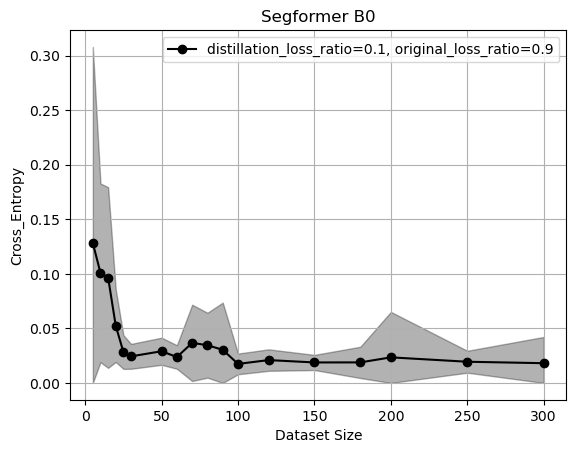

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()